In [9]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def get_btc_price_data():
    try:
        # Get BTC price data from Yahoo Finance
        btc = yf.download('BTC-USD', 
                         start=(datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d'),
                         end=datetime.now().strftime('%Y-%m-%d'))
        
        # Select only High, Low, Close
        btc = btc[['High', 'Low', 'Close']].reset_index()
        btc.columns = ['timestamp', 'high', 'low', 'close']
        print(f"Successfully downloaded {len(btc)} days of BTC price data")
        return btc
    except Exception as e:
        print(f"Error in get_btc_price_data: {str(e)}")
        return None

def calculate_mvrv_ratio():
    try:
        # Using Blockchain.com public API
        base_url = "https://api.blockchain.info/charts/"
        
        # Get Market Cap
        market_cap_response = requests.get(f"{base_url}market-cap?timespan=5years&format=json")
        market_cap = market_cap_response.json()
        
        # Get Total Coins
        total_coins_response = requests.get(f"{base_url}total-bitcoins?timespan=5years&format=json")
        total_coins = total_coins_response.json()
        
        # Create dataframes
        df_market = pd.DataFrame(market_cap['values'])
        df_coins = pd.DataFrame(total_coins['values'])
        
        print(f"Market cap data points: {len(df_market)}")
        print(f"Total coins data points: {len(df_coins)}")
        
        # Basic data validation
        if df_market.empty or df_coins.empty:
            raise ValueError("Empty data received from API")
        
        # Combine data
        df = pd.merge(df_market, df_coins, on='x')
        df.columns = ['timestamp', 'market_cap', 'total_coins']
        
        # Convert Unix timestamp to human readable date
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Ensure no zero values in total_coins to avoid division by zero
        df = df[df['total_coins'] > 0]
        
        # Calculate average price
        df['avg_price'] = df['market_cap'] / df['total_coins']
        
        # Calculate realized price (200-day moving average of avg_price)
        df['realized_price'] = df['avg_price'].rolling(window=200, min_periods=1).mean()
        
        # Calculate MVRV ratio
        df['mvrv_ratio'] = df['avg_price'] / df['realized_price']
        
        print(f"Successfully calculated MVRV for {len(df)} days")
        print("\nSample of calculated values:")
        print(df[['timestamp', 'avg_price', 'realized_price', 'mvrv_ratio']].head())
        
        return df
    
    except Exception as e:
        print(f"Error in calculate_mvrv_ratio: {str(e)}")
        return None

# Get data
try:
    # Get MVRV data
    mvrv_df = calculate_mvrv_ratio()
    if mvrv_df is None:
        raise ValueError("Failed to calculate MVRV ratio")
    
    # Get BTC price data
    btc_df = get_btc_price_data()
    if btc_df is None:
        raise ValueError("Failed to get BTC price data")
    
    # Convert timestamp to date for merging
    btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp']).dt.date
    btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
    
    # Merge the dataframes on timestamp
    final_df = pd.merge(mvrv_df, btc_df, on='timestamp', how='inner')
    
    # Verify we have data after merging
    if final_df.empty:
        raise ValueError("No data after merging")
    
    print(f"\nFinal dataset has {len(final_df)} rows")
    
    # Round numbers
    final_df = final_df.round({
        'market_cap': 2,
        'total_coins': 2,
        'avg_price': 2,
        'realized_price': 2,
        'mvrv_ratio': 4,
        'high': 2,
        'low': 2,
        'close': 2
    })
    
    # Save to CSV
    final_df.to_csv('btc_mvrv_and_price_data.csv', index=False, date_format='%Y-%m-%d')
    
    # Display statistical summary
    print("\nStatistical Summary:")
    print(final_df.describe())
    
    # Display first few rows
    print("\nFirst few rows of data:")
    print(final_df.head())
    
    # Check for null values
    null_counts = final_df.isnull().sum()
    print("\nNull value counts in each column:")
    print(null_counts)
    
except Exception as e:
    print(f"Main execution error: {str(e)}")

Market cap data points: 1498
Total coins data points: 1498
Successfully calculated MVRV for 1498 days

Sample of calculated values:
   timestamp  avg_price  realized_price  mvrv_ratio
0 2020-02-06     9630.0         9630.00    1.000000
1 2020-02-07     9769.5         9699.75    1.007191
2 2020-02-08     9823.5         9741.00    1.008469
3 2020-02-09    10082.0         9826.25    1.026027
4 2020-02-11     9766.0         9814.20    0.995089


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1825 days of BTC price data

Final dataset has 1497 rows

Statistical Summary:
                           timestamp    market_cap   total_coins  \
count                           1497  1.497000e+03  1.497000e+03   
mean   2022-08-07 17:44:50.981963776  7.338680e+11  1.910602e+07   
min              2020-02-06 00:00:00  8.468674e+10  1.820202e+07   
25%              2021-05-08 00:00:00  3.921241e+11  1.870388e+07   
50%              2022-08-11 00:00:00  6.467120e+11  1.911847e+07   
75%              2023-11-04 00:00:00  1.025212e+12  1.953331e+07   
max              2025-02-02 00:00:00  2.116991e+12  1.981849e+07   
std                              NaN  4.429898e+11  4.682600e+05   

           avg_price  realized_price   mvrv_ratio           high  \
count    1497.000000     1497.000000  1497.000000    1497.000000   
mean    38075.710261    33102.476740     1.190602   38849.458864   
min      4634.500000     7837.320000     0.425900    5371.350000   
25%     2053

In [11]:
final_df.describe()

,timestamp,market_cap,total_coins,avg_price,realized_price,mvrv_ratio,high,low,close
count,1497,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1497.000000,1497.00000,1497.000000
mean,2022-08-07 17:44:50.981963776,7.338680e+11,1.910602e+07,38075.710261,33102.476740,1.190602,38849.458864,37160.29008,38066.756613
min,2020-02-06 00:00:00,8.468674e+10,1.820202e+07,4634.500000,7837.320000,0.425900,5371.350000,4106.98000,4970.790000
25%,2021-05-08 00:00:00,3.921241e+11,1.870388e+07,20530.000000,20558.390000,0.936100,20913.320000,20076.12000,20471.480000
50%,2022-08-11 00:00:00,6.467120e+11,1.911847e+07,34384.000000,31010.530000,1.130800,35228.850000,33416.89000,34316.390000
75%,2023-11-04 00:00:00,1.025212e+12,1.953331e+07,54362.500000,46864.190000,1.351700,55410.230000,52514.33000,53991.460000
max,2025-02-02 00:00:00,2.116991e+12,1.981849e+07,106840.000000,75352.410000,3.051200,109114.880000,105291.73000,106140.600000
std,NaN,4.429898e+11,4.682600e+05,22410.098861,17320.871734,0.430843,22850.786663,21855.31399,22388.752406


Error creating plot: 'mvrv_zscore'


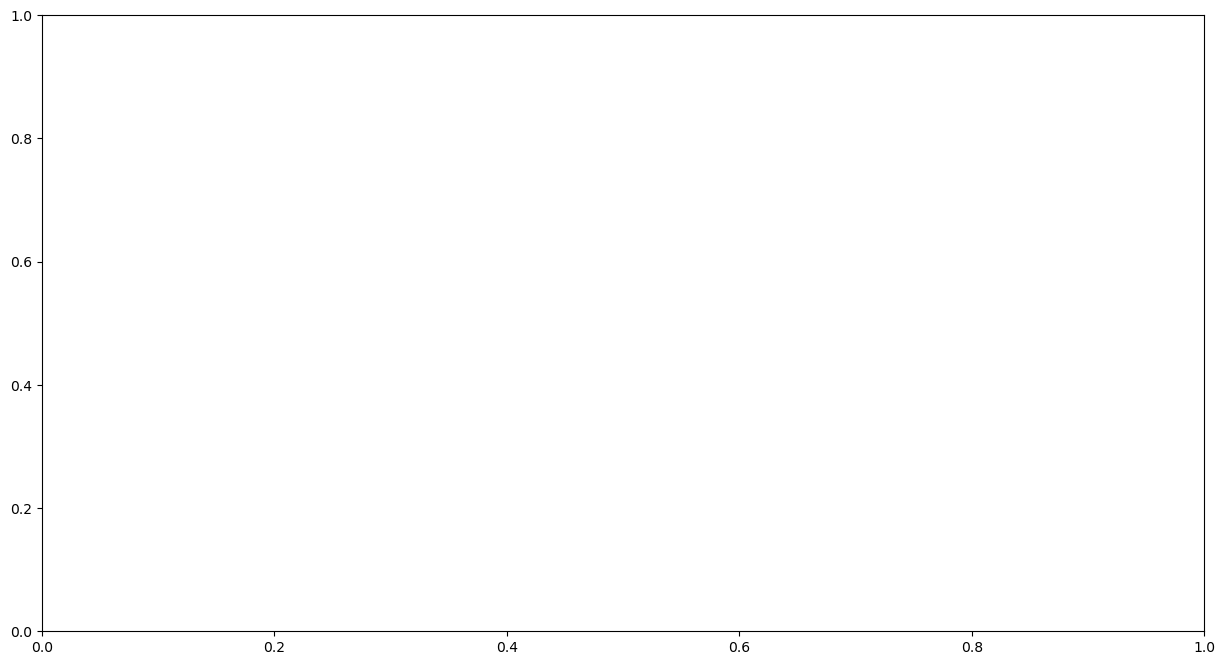

In [12]:
import matplotlib.pyplot as plt

def create_plot(mvrv_df):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot MVRV Z-Score
    ax.plot(mvrv_df['timestamp'], mvrv_df['mvrv_zscore'], color='blue', label='MVRV Z-Score')
    ax.set_ylabel('MVRV Z-Score', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True, alpha=0.3)
    
    # Add danger zone
    ax.axhspan(7, max(mvrv_df['mvrv_zscore'])*1.1, color='red', alpha=0.2, label='Danger Zone')
    
    # Format x-axis
    plt.title('Bitcoin MVRV Z-Score (5 Years)', pad=20)
    fig.autofmt_xdate()
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig('btc_mvrv_zscore.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nMVRV Z-Score Statistics:")
    print(mvrv_df['mvrv_zscore'].describe())

# Create plot
try:
    create_plot(mvrv_df)
except Exception as e:
    print(f"Error creating plot: {str(e)}")

Error creating plot: 'mvrv_zscore'


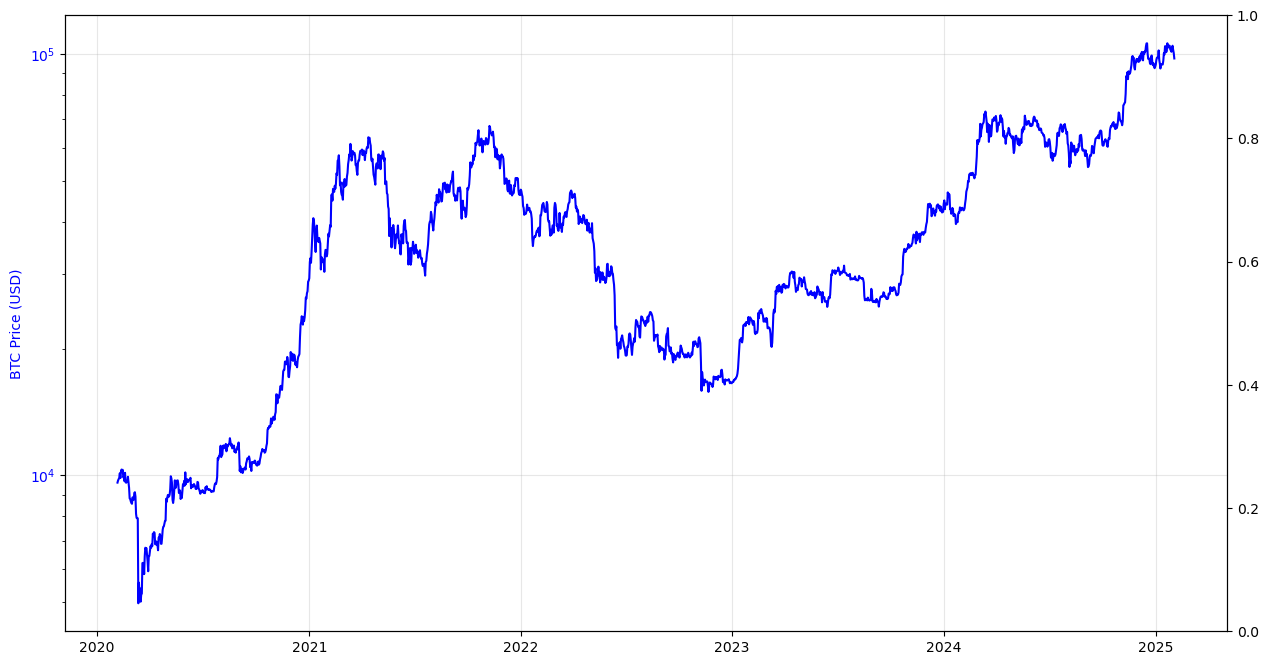

In [13]:
import matplotlib.pyplot as plt

def create_plot(mvrv_df, btc_df):
    # Create figure and axis objects with a single subplot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Add second y-axis sharing same x-axis
    ax2 = ax1.twinx()
    
    # Plot BTC price on first y-axis (log scale)
    ax1.semilogy(btc_df['timestamp'], btc_df['close'], color='blue', label='BTC Price')
    ax1.set_ylabel('BTC Price (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # Plot MVRV Z-Score on second y-axis (log scale)
    ax2.semilogy(mvrv_df['timestamp'], mvrv_df['mvrv_zscore'], color='red', label='MVRV Z-Score')
    ax2.set_ylabel('MVRV Z-Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add danger zone
    ax2.axhspan(7, max(mvrv_df['mvrv_zscore'])*1.1, color='red', alpha=0.2, label='Danger Zone')
    
    # Set title and format
    plt.title('Bitcoin Price vs MVRV Z-Score (5 Years)', pad=20)
    fig.autofmt_xdate()
    
    # Add both legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig('btc_mvrv_zscore_logscale.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print correlations
    merged_df = pd.merge(btc_df, mvrv_df, on='timestamp', how='inner')
    correlation = merged_df['close'].corr(merged_df['mvrv_zscore'])
    print(f"\nCorrelation between BTC Price and MVRV Z-Score: {correlation:.4f}")

# Create plot
try:
    create_plot(mvrv_df, btc_df)
except Exception as e:
    print(f"Error creating plot: {str(e)}")

SyntaxError: incomplete input (3945256965.py, line 68)

In [30]:
df.describe()

,timestamp,market_cap,total_coins,mining_revenue,price,realized_price,price_std,mvrv_zscore,mining_revenue_ma365,puell_multiple
count,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def calculate_indicators():
    try:
        # Using Blockchain.com public API
        base_url = "https://api.blockchain.info/charts/"
        
        # Get Market Cap
        market_cap_response = requests.get(f"{base_url}market-cap?timespan=5years&format=json")
        market_cap = market_cap_response.json()
        
        # Get Total Coins
        total_coins_response = requests.get(f"{base_url}total-bitcoins?timespan=5years&format=json")
        total_coins = total_coins_response.json()
        
        # Get Mining Revenue
        mining_revenue_response = requests.get(f"{base_url}miners-revenue?timespan=5years&format=json")
        mining_revenue = mining_revenue_response.json()
        
        # Create dataframes and properly name columns
        df_market = pd.DataFrame(market_cap['values'])
        df_market.columns = ['timestamp', 'market_cap']
        
        df_coins = pd.DataFrame(total_coins['values'])
        df_coins.columns = ['timestamp', 'total_coins']
        
        df_mining = pd.DataFrame(mining_revenue['values'])
        df_mining.columns = ['timestamp', 'mining_revenue']
        
        # Merge dataframes on timestamp
        df = pd.merge(df_market, df_coins, on='timestamp')
        df = pd.merge(df, df_mining, on='timestamp')
        
        # Convert Unix timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        
        # Calculate price
        df['price'] = df['market_cap'] / df['total_coins']
        
        # Calculate moving averages and standard deviation
        df['price_ma200'] = df['price'].rolling(window=200, min_periods=1).mean()
        df['price_std'] = df['price'].rolling(window=200, min_periods=1).std()
        df['mining_revenue_ma365'] = df['mining_revenue'].rolling(window=365, min_periods=1).mean()
        
        # Calculate MVRV Z-Score
        df['mvrv_zscore'] = (df['price'] - df['price_ma200']) / df['price_std']
        
        # Calculate Puell Multiple
        df['puell_multiple'] = df['mining_revenue'] / df['mining_revenue_ma365']
        
        # Drop any NaN values
        df = df.dropna()
        
        print("\nData Sample:")
        print(df[['timestamp', 'price', 'mvrv_zscore', 'puell_multiple']].head())
        print("\nShape:", df.shape)
        print("\nDescriptive Statistics:")
        print(df[['price', 'mvrv_zscore', 'puell_multiple']].describe())
        
        return df
    
    except Exception as e:
        print(f"Error in calculate_indicators: {str(e)}")
        raise e

# Test the calculation
try:
    df = calculate_indicators()
    
    # Verify data
    if df is not None and not df.empty:
        print("\nVerification of calculations:")
        print("MVRV Z-Score range:", df['mvrv_zscore'].min(), "to", df['mvrv_zscore'].max())
        print("Puell Multiple range:", df['puell_multiple'].min(), "to", df['puell_multiple'].max())
    else:
        print("No data available")
        
except Exception as e:
    print(f"Error: {str(e)}")


Data Sample:
Empty DataFrame
Columns: [timestamp, price, mvrv_zscore, puell_multiple]
Index: []

Shape: (0, 10)

Descriptive Statistics:
       price  mvrv_zscore  puell_multiple
count    0.0          0.0             0.0
mean     NaN          NaN             NaN
std      NaN          NaN             NaN
min      NaN          NaN             NaN
25%      NaN          NaN             NaN
50%      NaN          NaN             NaN
75%      NaN          NaN             NaN
max      NaN          NaN             NaN
No data available


In [38]:
df.describe()  

,timestamp,market_cap,total_coins,mining_revenue,price,price_ma200,price_std,mining_revenue_ma365,mvrv_zscore,puell_multiple
count,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
